In [0]:
!curl -O https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  18.4M      0 --:--:-- --:--:-- --:--:-- 18.4M
Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating

In [0]:
import glob
import unicodedata
import string
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [0]:
device

device(type='cuda')

In [0]:
filenames = glob.glob('data/names/*.txt')

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [0]:
def unicode_to_ascii(s):
  return ''.join(
    c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
    )
def readlines(fname):
  lines = open(fname, encoding='utf-8').read().strip().split('\n')
  return list(set([unicode_to_ascii(line) for line in lines]))

In [0]:
categories=[]
category_dict = {}
for fname in filenames:
  cat=os.path.splitext(os.path.basename(fname))[0]
  categories.append(cat)
  category_dict[cat] = readlines(fname)
n_categories = len(categories)

In [0]:
def letter_to_index(l):
  return all_letters.find(l)
def letter_to_tensor(l):
  ten = torch.zeros(1, n_letters)
  ten[0,letter_to_index(l)] = 1.0
  return ten
def string_to_tensor(s):
  ten = torch.zeros(len(s),1,n_letters,device=device)
  for i, l in enumerate(s):
    ten[i][0][letter_to_index(l)] = 1.0
  return ten

In [0]:
[letter_to_tensor(l) for l in category_dict['German'][0]]
print(string_to_tensor(category_dict['German'][0]).size())

torch.Size([3, 1, 57])


In [0]:
class Rnn(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(Rnn, self).__init__()
    
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden
  def initHidden(self):
    return torch.zeros(1, self.hidden_size,device=device)

n_hidden = 128

In [0]:
def categoryFromOutput(out):
  top_n, top_i = out.topk(1)
  cat_i = top_i[0].item()
  return categories[cat_i], cat_i, top_n[0].item()

In [0]:
def randomChoice(l):
  return l[random.randint(0,len(l)-1)]
def randomTrainingExample():
  cat = randomChoice(categories)
  line = randomChoice(category_dict[cat])
  cat_tensor = torch.tensor([categories.index(cat)], dtype=torch.long,device=device)
  line_tensor = string_to_tensor(line)
  return cat, line, cat_tensor, line_tensor

In [0]:
rnn = Rnn(n_letters, n_hidden, n_categories)
rnn.cuda()
criterion = nn.NLLLoss() 
learning_rate = 0.005
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)

In [0]:
def train(category_tensor, line_tesor):
  hidden = rnn.initHidden()
  
  optimizer.zero_grad()
  
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  
  loss = criterion(output, category_tensor)
  loss.backward()
  optimizer.step()  
  return output, loss.item()

In [0]:
n_iters = 1000000
print_every = 5000
plot_every = 1000

In [0]:
def timeSince(t):
  now = time.time()
  s = now - t
  m = math.floor(s/60)
  s -= m*60
  return '{}:{}'.format(m,s)

In [0]:
current_loss = 0
all_losses = []
start = time.time()

for iter in range(1, n_iters+1):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss
  
  if iter % print_every == 0:
    guess, guess_i, _ = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ ({})'.format(category)
    print('{} {}% ({}) {} {} / {} {}'.format(iter, iter / n_iters * 100,
                                             timeSince(start), loss, line,
                                             guess, correct))
  if iter % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0

5000 0.5% (0:10.279640436172485) 2.948561906814575 Mcguire / Japanese ✗ (Irish)
10000 1.0% (0:20.640615701675415) 2.591064214706421 Michael / Japanese ✗ (Irish)
15000 1.5% (0:30.64179229736328) 2.268768310546875 Lesauvage / Italian ✗ (French)
20000 2.0% (0:40.274611949920654) 1.7030527591705322 Selvaggio / Italian ✓
25000 2.5% (0:49.91952419281006) 1.6270794868469238 Ryu / Chinese ✗ (Korean)
30000 3.0% (0:59.57618284225464) 1.9095617532730103 Bell / German ✗ (Scottish)
35000 3.5000000000000004% (1:9.148215770721436) 0.7233662605285645 Pavlicka / Czech ✓
40000 4.0% (1:18.868011951446533) 1.740581750869751 Leverenz / Dutch ✗ (German)
45000 4.5% (1:28.826258897781372) 2.0176541805267334 Glaisyer / German ✗ (French)
50000 5.0% (1:39.463034868240356) 0.8645153045654297 Basurto / Portuguese ✓
55000 5.5% (1:48.9641695022583) 1.7340761423110962 Pudel / Czech ✓
60000 6.0% (1:58.57266712188721) 3.6889781951904297 Cameron / Irish ✗ (Scottish)
65000 6.5% (2:8.20088529586792) 2.2502119541168213 Blu

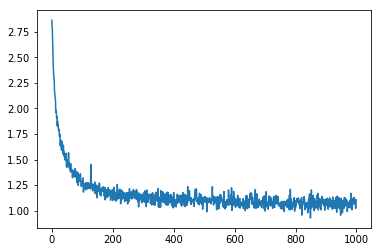

In [0]:
plt.figure()
plt.plot(all_losses)

In [0]:
def evaluate(line_tensor):
  hidden = rnn.initHidden()
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  return output

In [0]:
confusion = torch.zeros(n_categories, n_categories, device=device)
n_confusion = 10000
for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i, _ = categoryFromOutput(output)
  category_i = categories.index(category)
  confusion[category_i][guess_i] += 1

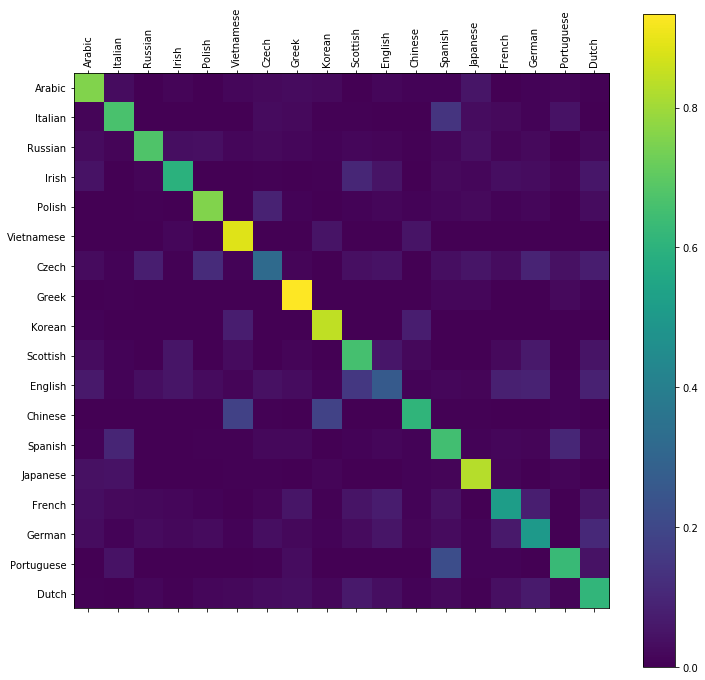

In [0]:
for i in range(n_categories):
  confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.cpu().numpy())
fig.colorbar(cax)
ax.set_xticklabels(['']+categories,rotation=90)
ax.set_yticklabels(['']+categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()